# Restaurant Recommendation System

# Libraries Import

In [1]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
import re
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentIntensityAnalyzer

# Data Import

In [2]:
TA_file = "Malaysia Restaurant Review Datasets/data_cleaned/TripAdvisor_data_cleaned.csv"
tripadvisor_review_master = pd.read_csv(TA_file)

In [111]:
# Data export for deployment
tripadvisor_review_master.to_csv('oldreviews.csv', index=False)

# Exploratory Data Analysis

In [3]:
print('Total unique restaurants: '+str(len(tripadvisor_review_master['Restaurant'].unique())))
print('Total unique users: '+str(len(tripadvisor_review_master['Author'].unique())))
tripadvisor_review_master.shape

Total unique restaurants: 2544
Total unique users: 94602


(139764, 7)

In [4]:
tripadvisor_review = tripadvisor_review_master
tripadvisor_review.head()

,Author,Title,Review,Rating,Dates,Restaurant,Location
0,kmc1e2018,Chambers Bar and Grill,"David, Thanga, Mikail and Chef Steven gave bri...",5.0,Reviewed yesterday,Chambers Grill,KL
1,"MizOthmanKuala Lumpur, Malaysia",Always a pleasure. Place to celebrate.,We visited for family celebration and as usual...,5.0,Reviewed 5 days ago,Chambers Grill,KL
2,"Relax36268533224Hjarno, Denmark",Enjoying good service and good food after a lo...,Perfect dinner after a long journey.After trav...,5.0,Reviewed 1 week ago,Chambers Grill,KL
3,tstrry,Great Steak for Couples,Had a great Tomahawk for me and hubby thanks t...,5.0,Reviewed 1 week ago,Chambers Grill,KL
4,Naim_123456789,Dining,"Excellent ambient. Excellent service by David,...",5.0,Reviewed 1 week ago,Chambers Grill,KL


In [243]:
def toprated():
    # Calculate average ratings and number of restaurants
    average_rating = tripadvisor_review.groupby('Restaurant')['Rating'].agg(['mean', 'count']).reset_index()
    average_rating.columns = ['Restaurant', 'Mean', 'Num']
    average_rating = average_rating.sort_values(by=['Mean', 'Num'], ascending=False)
    return average_rating

toprated()

,Restaurant,Mean,Num
1577,Pool Bar & Grill,5.0,34
1592,Puree Juice,5.0,30
283,Busdriver.Cafe,5.0,20
1092,Le Shady Trinity Cafe,5.0,20
120,Aryan Restaurant,5.0,18
...,...,...,...
1528,Penang Road Famous Teochew Chendul,1.0,1
1624,Raw - Brew & Dine,1.0,1
2176,Ten Here Cafe,1.0,1
2440,Warung Plus Plus,1.0,1


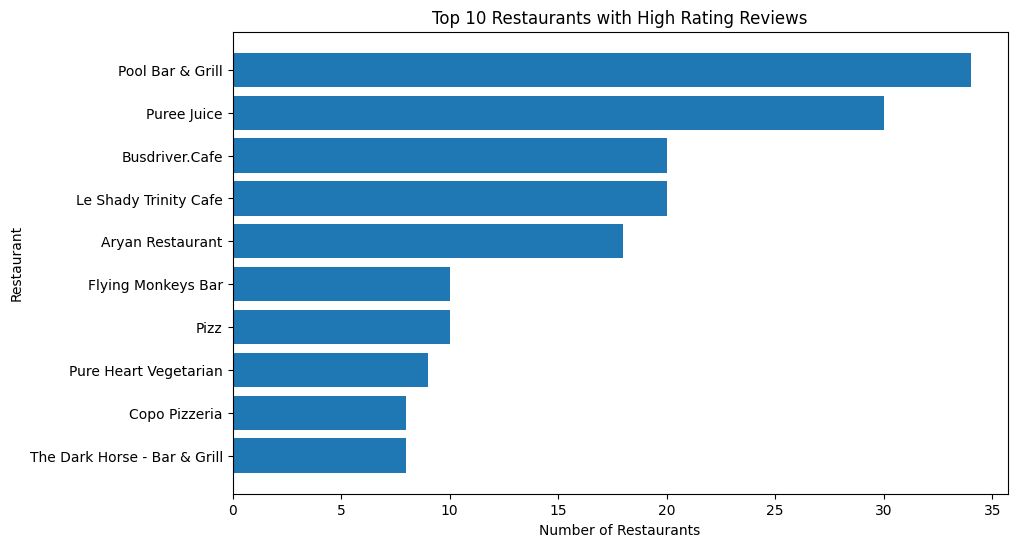

In [244]:
# Plot the horizontal bar chart for top 10 restaurants
top_10_restaurants = toprated().head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_10_restaurants['Restaurant'], top_10_restaurants['Num'])
plt.xlabel('Number of Restaurants')
plt.ylabel('Restaurant')
plt.title('Top 10 Restaurants with High Rating Reviews')
plt.gca().invert_yaxis()
plt.show()

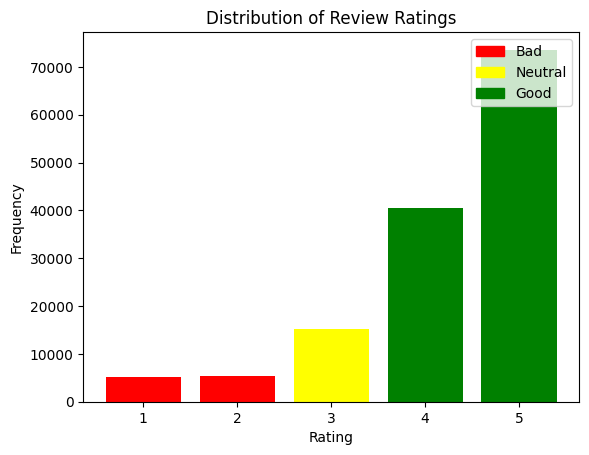

In [200]:
ratings = tripadvisor_review['Rating']
# Define the colors for different rating categories
color_map = {1: 'red', 2: 'red', 3: 'yellow', 4: 'green', 5: 'green'}

# Count the frequency of each rating category
rating_counts = ratings.value_counts().sort_index()

# Plot the histogram
plt.bar(rating_counts.index, rating_counts, color=[color_map[rating] for rating in rating_counts.index])

# Set the labels and title
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Review Ratings')

# Create custom legend
legend_labels = ['Bad', 'Neutral', 'Good']
legend_colors = ['red', 'yellow', 'green']
legend_patches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in legend_colors]
plt.legend(legend_patches, legend_labels, loc='upper right')

# Show the plot
plt.show()

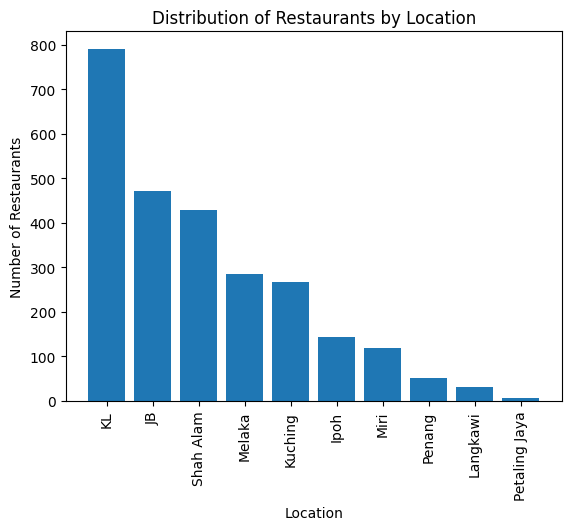

In [202]:
restaurant_counts = tripadvisor_review.groupby('Location')['Restaurant'].nunique()

# Sort the restaurant counts in descending order
restaurant_counts = restaurant_counts.sort_values(ascending=False)

# Create a bar chart
plt.bar(restaurant_counts.index, restaurant_counts)

# Set the x-label rotation for better readability
plt.xticks(rotation=90)

# Set the title and labels
plt.title('Distribution of Restaurants by Location')
plt.xlabel('Location')
plt.ylabel('Number of Restaurants')

# Show the plot
plt.show()

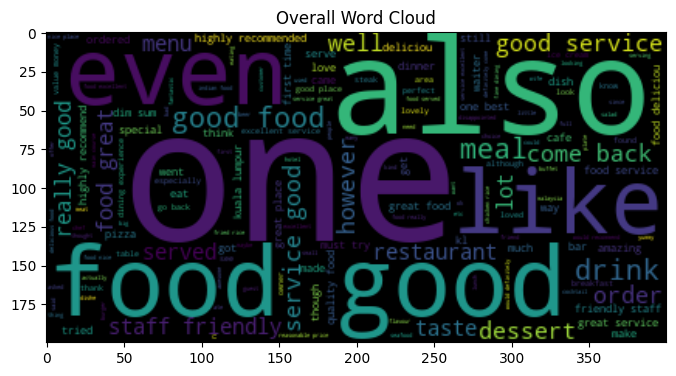

In [17]:
sw = set(stopwords.words("english"))
# Overall Word Cloud
def get_top_n_unigrams(df, column, n=20):
    texts = " ".join(review.lower() for review in df[column])
    tokenizer = RegexpTokenizer(r"\w+")
    tokens = tokenizer.tokenize(texts)
    tokens = [token for token in tokens if token not in sw]
    unigrams = FreqDist(tokens).most_common(n)
    return unigrams

overall_unigram = get_top_n_unigrams(tripadvisor_review, "Review", n=20)

overallUnigram_df = pd.DataFrame(overall_unigram, columns=['Unigram', 'Count'])

# creating word cloud
wcoverall = WordCloud(stopwords=set(sw)).generate(" ".join(tokens))

plt.figure(figsize=(8, 6))  # Adjust the figure size according to your preference
plt.imshow(wcoverall, interpolation='bilinear')
plt.title('Overall Word Cloud')  # Add the title to the word cloud
plt.show()  # Display the word cloud

['food', 'good', 'service', 'great', 'place']
['food', 'restaurant', 'service', 'us', 'good']


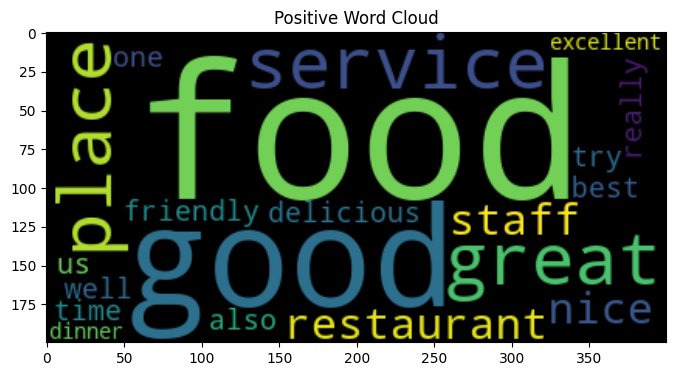

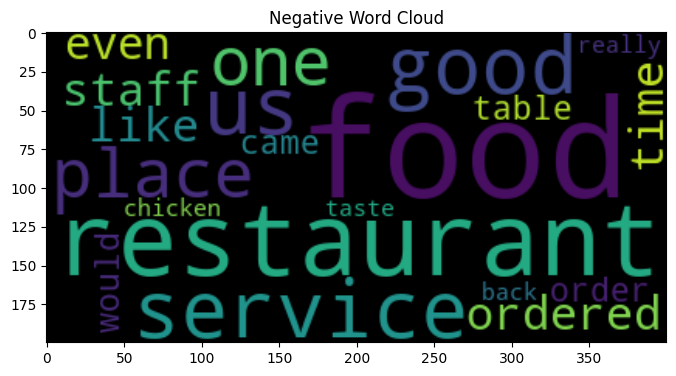

In [25]:
# Positive and Negative Word Clouds
df_positive = tripadvisor_review[tripadvisor_review["Rating"] > 3]
df_negative = tripadvisor_review[tripadvisor_review["Rating"] < 3]

positive_unigram = get_top_n_unigrams(df_positive, "Review", n=20)
negative_unigram = get_top_n_unigrams(df_negative, "Review", n=20)

positive_unigram_words = [word for word, count in positive_unigram]
negative_unigram_words = [word for word, count in negative_unigram]

wcloud_positive = WordCloud(stopwords=set(sw)).generate(" ".join(positive_unigram_words))
wcloud_negative = WordCloud(stopwords=set(sw)).generate(" ".join(negative_unigram_words))

print(positive_unigram_words[:5])
print(negative_unigram_words[:5])

plt.figure(figsize=(8, 6))
plt.imshow(wcloud_positive, interpolation='bilinear')
plt.title('Positive Word Cloud')
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(wcloud_negative, interpolation='bilinear')
plt.title('Negative Word Cloud')
plt.show()

# Data Preprocessing

In [5]:
#Adding Sentiment Tag
def map_rating_to_sentiment(rating):
    if rating > 3:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

# Apply the function to create a new column 'sentiment'
tripadvisor_review['sentiment'] = tripadvisor_review['Rating'].apply(map_rating_to_sentiment)

tripadvisor_review.head()

,Author,Title,Review,Rating,Dates,Restaurant,Location,sentiment
0,kmc1e2018,Chambers Bar and Grill,"David, Thanga, Mikail and Chef Steven gave bri...",5.0,Reviewed yesterday,Chambers Grill,KL,Positive
1,"MizOthmanKuala Lumpur, Malaysia",Always a pleasure. Place to celebrate.,We visited for family celebration and as usual...,5.0,Reviewed 5 days ago,Chambers Grill,KL,Positive
2,"Relax36268533224Hjarno, Denmark",Enjoying good service and good food after a lo...,Perfect dinner after a long journey.After trav...,5.0,Reviewed 1 week ago,Chambers Grill,KL,Positive
3,tstrry,Great Steak for Couples,Had a great Tomahawk for me and hubby thanks t...,5.0,Reviewed 1 week ago,Chambers Grill,KL,Positive
4,Naim_123456789,Dining,"Excellent ambient. Excellent service by David,...",5.0,Reviewed 1 week ago,Chambers Grill,KL,Positive


In [6]:
def preprocess_df(df):
    tripadvisor_review['restaurant_id'] = tripadvisor_review['Restaurant'].factorize()[0] + 1
    tripadvisor_review['user_id'] = tripadvisor_review['Author'].factorize()[0] + 1
    tripadvisor_review['Total_Reviews_By_Restaurant'] = tripadvisor_review['Restaurant'].map(tripadvisor_review['Restaurant'].value_counts())
    tripadvisor_review['TotalReviewsGiven'] = tripadvisor_review.groupby('Author')['Rating'].transform('count')

    return tripadvisor_review

tripadvisor_review = preprocess_df(tripadvisor_review)

tripadvisor_review.head()

,Author,Title,Review,Rating,Dates,Restaurant,Location,sentiment,restaurant_id,user_id,Total_Reviews_By_Restaurant,TotalReviewsGiven
0,kmc1e2018,Chambers Bar and Grill,"David, Thanga, Mikail and Chef Steven gave bri...",5.0,Reviewed yesterday,Chambers Grill,KL,Positive,1,1,703,1
1,"MizOthmanKuala Lumpur, Malaysia",Always a pleasure. Place to celebrate.,We visited for family celebration and as usual...,5.0,Reviewed 5 days ago,Chambers Grill,KL,Positive,1,2,703,3
2,"Relax36268533224Hjarno, Denmark",Enjoying good service and good food after a lo...,Perfect dinner after a long journey.After trav...,5.0,Reviewed 1 week ago,Chambers Grill,KL,Positive,1,3,703,1
3,tstrry,Great Steak for Couples,Had a great Tomahawk for me and hubby thanks t...,5.0,Reviewed 1 week ago,Chambers Grill,KL,Positive,1,4,703,1
4,Naim_123456789,Dining,"Excellent ambient. Excellent service by David,...",5.0,Reviewed 1 week ago,Chambers Grill,KL,Positive,1,5,703,1


In [7]:
# special character removal, alphanumeric character removal and remain all the alphabet words
def word_exists(word):
    synsets = wordnet.synsets(word)
    return len(synsets) > 0

# Remove special characters and alphanumeric characters
# Remove leading/trailing whitespaces
# Remove multiple consecutive spaces
def clean_tags(tags):
    cleaned_tags = re.sub('[^a-zA-Z ]', '', tags)  
    cleaned_tags = cleaned_tags.strip()  
    cleaned_tags = re.sub(' +', ' ', cleaned_tags)  
    return cleaned_tags

# Combining Title and Review columns to become a single tags column
tripadvisor_review['Review'] = tripadvisor_review['Title'] + " " + tripadvisor_review['Review']
tripadvisor_review['tags'] = tripadvisor_review['Review'].apply(clean_tags)
tripadvisor_review = tripadvisor_review.drop('Title', axis=1)
tripadvisor_review = tripadvisor_review.drop('Dates', axis=1)
tripadvisor_review = tripadvisor_review.drop('Review', axis=1)

tripadvisor_review['cleaned_restaurant'] = tripadvisor_review['Restaurant'].apply(clean_tags)
tripadvisor_review.head()

,Author,Rating,Restaurant,Location,sentiment,restaurant_id,user_id,Total_Reviews_By_Restaurant,TotalReviewsGiven,tags,cleaned_restaurant
0,kmc1e2018,5.0,Chambers Grill,KL,Positive,1,1,703,1,Chambers Bar and Grill David Thanga Mikail and...,Chambers Grill
1,"MizOthmanKuala Lumpur, Malaysia",5.0,Chambers Grill,KL,Positive,1,2,703,3,Always a pleasure Place to celebrate We visite...,Chambers Grill
2,"Relax36268533224Hjarno, Denmark",5.0,Chambers Grill,KL,Positive,1,3,703,1,Enjoying good service and good food after a lo...,Chambers Grill
3,tstrry,5.0,Chambers Grill,KL,Positive,1,4,703,1,Great Steak for Couples Had a great Tomahawk f...,Chambers Grill
4,Naim_123456789,5.0,Chambers Grill,KL,Positive,1,5,703,1,Dining Excellent ambient Excellent service by ...,Chambers Grill


In [8]:
tripadvisor_review["tags"] = tripadvisor_review["tags"].str.lower()
tripadvisor_review["cleaned_restaurant"] = tripadvisor_review["cleaned_restaurant"].str.lower()
tripadvisor_review.head()

,Author,Rating,Restaurant,Location,sentiment,restaurant_id,user_id,Total_Reviews_By_Restaurant,TotalReviewsGiven,tags,cleaned_restaurant
0,kmc1e2018,5.0,Chambers Grill,KL,Positive,1,1,703,1,chambers bar and grill david thanga mikail and...,chambers grill
1,"MizOthmanKuala Lumpur, Malaysia",5.0,Chambers Grill,KL,Positive,1,2,703,3,always a pleasure place to celebrate we visite...,chambers grill
2,"Relax36268533224Hjarno, Denmark",5.0,Chambers Grill,KL,Positive,1,3,703,1,enjoying good service and good food after a lo...,chambers grill
3,tstrry,5.0,Chambers Grill,KL,Positive,1,4,703,1,great steak for couples had a great tomahawk f...,chambers grill
4,Naim_123456789,5.0,Chambers Grill,KL,Positive,1,5,703,1,dining excellent ambient excellent service by ...,chambers grill


In [9]:
# text mining pre-processing techniques, words split, stop words removal, punctuation removal.
def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    return tokens

tripadvisor_review['tags'] = tripadvisor_review['tags'].apply(tokenize_text)

tripadvisor_review.head()

,Author,Rating,Restaurant,Location,sentiment,restaurant_id,user_id,Total_Reviews_By_Restaurant,TotalReviewsGiven,tags,cleaned_restaurant
0,kmc1e2018,5.0,Chambers Grill,KL,Positive,1,1,703,1,"[chambers, bar, and, grill, david, thanga, mik...",chambers grill
1,"MizOthmanKuala Lumpur, Malaysia",5.0,Chambers Grill,KL,Positive,1,2,703,3,"[always, a, pleasure, place, to, celebrate, we...",chambers grill
2,"Relax36268533224Hjarno, Denmark",5.0,Chambers Grill,KL,Positive,1,3,703,1,"[enjoying, good, service, and, good, food, aft...",chambers grill
3,tstrry,5.0,Chambers Grill,KL,Positive,1,4,703,1,"[great, steak, for, couples, had, a, great, to...",chambers grill
4,Naim_123456789,5.0,Chambers Grill,KL,Positive,1,5,703,1,"[dining, excellent, ambient, excellent, servic...",chambers grill


In [10]:
def remove_notenglish_words(tags):
    cleaned_tags = [tag for tag in tags if word_exists(tag)]
    return cleaned_tags

tripadvisor_review['tags'] = tripadvisor_review['tags'].apply(remove_notenglish_words)

tripadvisor_review.head()

,Author,Rating,Restaurant,Location,sentiment,restaurant_id,user_id,Total_Reviews_By_Restaurant,TotalReviewsGiven,tags,cleaned_restaurant
0,kmc1e2018,5.0,Chambers Grill,KL,Positive,1,1,703,1,"[chambers, bar, grill, david, chef, gave, bril...",chambers grill
1,"MizOthmanKuala Lumpur, Malaysia",5.0,Chambers Grill,KL,Positive,1,2,703,3,"[always, a, pleasure, place, celebrate, visite...",chambers grill
2,"Relax36268533224Hjarno, Denmark",5.0,Chambers Grill,KL,Positive,1,3,703,1,"[enjoying, good, service, good, food, after, a...",chambers grill
3,tstrry,5.0,Chambers Grill,KL,Positive,1,4,703,1,"[great, steak, couples, had, a, great, tomahaw...",chambers grill
4,Naim_123456789,5.0,Chambers Grill,KL,Positive,1,5,703,1,"[dining, excellent, ambient, excellent, servic...",chambers grill


In [11]:
def remove_urls(tokens):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    filtered_tokens = [token for token in tokens if not url_pattern.match(token)]
    return filtered_tokens

tripadvisor_review['tags'] = tripadvisor_review['tags'].apply(remove_urls)
tripadvisor_review['tags'] = tripadvisor_review['tags'].apply(lambda tokens: ' '.join(tokens))
tripadvisor_review.head()

,Author,Rating,Restaurant,Location,sentiment,restaurant_id,user_id,Total_Reviews_By_Restaurant,TotalReviewsGiven,tags,cleaned_restaurant
0,kmc1e2018,5.0,Chambers Grill,KL,Positive,1,1,703,1,chambers bar grill david chef gave brilliant s...,chambers grill
1,"MizOthmanKuala Lumpur, Malaysia",5.0,Chambers Grill,KL,Positive,1,2,703,3,always a pleasure place celebrate visited fami...,chambers grill
2,"Relax36268533224Hjarno, Denmark",5.0,Chambers Grill,KL,Positive,1,3,703,1,enjoying good service good food after a long j...,chambers grill
3,tstrry,5.0,Chambers Grill,KL,Positive,1,4,703,1,great steak couples had a great tomahawk me hu...,chambers grill
4,Naim_123456789,5.0,Chambers Grill,KL,Positive,1,5,703,1,dining excellent ambient excellent service by ...,chambers grill


In [12]:
# Count the total reviews received by each restaurant
restaurant_reviews_count = tripadvisor_review['restaurant_id'].value_counts()

# Filter restaurants with review count more than 100
restaurants_to_drop = restaurant_reviews_count[restaurant_reviews_count > 20].index

# Filter authors with only one review
authors_to_drop = tripadvisor_review['Author'].value_counts()[tripadvisor_review['Author'].value_counts() <=10].index

# Randomly drop rows for selected restaurants and authors
randomly_dropped_ratings = tripadvisor_review.drop(tripadvisor_review[(tripadvisor_review['restaurant_id'].isin(restaurants_to_drop)) & (tripadvisor_review['Author'].isin(authors_to_drop))].sample(frac=1).index)

# Verify the updated counts
updated_reviews_count = randomly_dropped_ratings['restaurant_id'].value_counts()

# Display the updated DataFrame
print(randomly_dropped_ratings)

                                     Author  Rating   
214                            Journey43268     5.0  \
364                            Journey43268     5.0   
412                            Journey43268     5.0   
524      BobBobGoldenKuala Lumpur, Malaysia     4.0   
543                            Journey43268     5.0   
...                                     ...     ...   
139711                         FlorenceH747     5.0   
139712  johnfooJohor Bahru, Johor, Malaysia     5.0   
139713          HcleneJohor Bahru, Malaysia     4.0   
139714              genevynn lSuzhou, China     5.0   
139732   jonathany689Kuala Lumpur, Malaysia     4.0   

                        Restaurant Location sentiment  restaurant_id  user_id   
214                 Chambers Grill       KL  Positive              1      212  \
364                 Chambers Grill       KL  Positive              1      212   
412                 Chambers Grill       KL  Positive              1      212   
524            

In [13]:
# Display the total number of unique author and restaurant before preprocess
tripadvisor_review.shape
print(len(tripadvisor_review['Author'].unique()))
print(len(tripadvisor_review['Restaurant'].unique()))

94602
2544


In [14]:
# Display the total number of unique author and restaurant after preprocess
print(len(randomly_dropped_ratings['Author'].unique())) # total number of unique authors in df
print(len(randomly_dropped_ratings['Restaurant'].unique()))
print(len(randomly_dropped_ratings['Author'])) # total number of authors in df

8418
2496
19055


In [15]:
randomly_dropped_ratings['tags'] = randomly_dropped_ratings['tags'] + " " + tripadvisor_review['cleaned_restaurant']
randomly_dropped_ratings.head()

,Author,Rating,Restaurant,Location,sentiment,restaurant_id,user_id,Total_Reviews_By_Restaurant,TotalReviewsGiven,tags,cleaned_restaurant
214,Journey43268,5.0,Chambers Grill,KL,Positive,1,212,703,38,superb dinner first time dining after been rec...,chambers grill
364,Journey43268,5.0,Chambers Grill,KL,Positive,1,212,703,38,birthday dinner food service excellent by cham...,chambers grill
412,Journey43268,5.0,Chambers Grill,KL,Positive,1,212,703,38,excellence great food prepared by chef chef ch...,chambers grill
524,"BobBobGoldenKuala Lumpur, Malaysia",4.0,Chambers Grill,KL,Positive,1,494,703,18,very nice steak bar is very well renovated ser...,chambers grill
543,Journey43268,5.0,Chambers Grill,KL,Positive,1,212,703,38,table side tomahawk tried a tomahawk is recomm...,chambers grill


In [16]:
def remove_duplicates(tags):
    # Remove punctuation from the tags
    tags = ''.join([char for char in tags if char not in string.punctuation])
    
    tag_list = tags.split()  # Split the tags into a list of words
    unique_tags = []
    for tag in tag_list:
        if tag not in unique_tags:
            unique_tags.append(tag)  # Append the word to the unique_tags list if it's not already present
    cleaned_tags = ' '.join(unique_tags)  # Join the unique_tags list back into a string
    return cleaned_tags

randomly_dropped_ratings['tags'] = randomly_dropped_ratings['tags'].apply(remove_duplicates)
randomly_dropped_ratings.head()

,Author,Rating,Restaurant,Location,sentiment,restaurant_id,user_id,Total_Reviews_By_Restaurant,TotalReviewsGiven,tags,cleaned_restaurant
214,Journey43268,5.0,Chambers Grill,KL,Positive,1,212,703,38,superb dinner first time dining after been rec...,chambers grill
364,Journey43268,5.0,Chambers Grill,KL,Positive,1,212,703,38,birthday dinner food service excellent by cham...,chambers grill
412,Journey43268,5.0,Chambers Grill,KL,Positive,1,212,703,38,excellence great food prepared by chef tomahaw...,chambers grill
524,"BobBobGoldenKuala Lumpur, Malaysia",4.0,Chambers Grill,KL,Positive,1,494,703,18,very nice steak bar is well renovated serve gr...,chambers grill
543,Journey43268,5.0,Chambers Grill,KL,Positive,1,212,703,38,table side tomahawk tried a is recommended by ...,chambers grill


In [17]:
stemmer = PorterStemmer()

# Stemming
def stem_tags(tags):
    stemmed_tags = [stemmer.stem(tag) for tag in tags.split()]
    stemmed_tags_str = ' '.join(stemmed_tags)
    return stemmed_tags_str

randomly_dropped_ratings['tags'] = randomly_dropped_ratings['tags'].apply(stem_tags)
randomly_dropped_ratings.head()

,Author,Rating,Restaurant,Location,sentiment,restaurant_id,user_id,Total_Reviews_By_Restaurant,TotalReviewsGiven,tags,cleaned_restaurant
214,Journey43268,5.0,Chambers Grill,KL,Positive,1,212,703,38,superb dinner first time dine after been recei...,chambers grill
364,Journey43268,5.0,Chambers Grill,KL,Positive,1,212,703,38,birthday dinner food servic excel by chamber m...,chambers grill
412,Journey43268,5.0,Chambers Grill,KL,Positive,1,212,703,38,excel great food prepar by chef tomahawk perfe...,chambers grill
524,"BobBobGoldenKuala Lumpur, Malaysia",4.0,Chambers Grill,KL,Positive,1,494,703,18,veri nice steak bar is well renov serv great i...,chambers grill
543,Journey43268,5.0,Chambers Grill,KL,Positive,1,212,703,38,tabl side tomahawk tri a is recommend by prese...,chambers grill


In [242]:
# Export for deployment purpose
randomly_dropped_ratings.to_csv("cleaned_rdataset.csv", index=False)

# Content Based Filtering

In [18]:
# Create an instance of CountVectorizer and stop words removal is done before creating the model.
cv = CountVectorizer(max_features=20000, stop_words='english')

# Fit and transform the text data into a sparse matrix
vectors = cv.fit_transform(randomly_dropped_ratings['tags'])

vectors

<19055x11807 sparse matrix of type '<class 'numpy.int64'>'
	with 640053 stored elements in Compressed Sparse Row format>

In [19]:
similarity = cosine_similarity(vectors)

similarity

array([[1.        , 0.35007002, 0.25928149, ..., 0.        , 0.        ,
        0.1266601 ],
       [0.35007002, 1.        , 0.54006172, ..., 0.04950738, 0.04402255,
        0.20100756],
       [0.25928149, 0.54006172, 1.        , ..., 0.09166985, 0.08151391,
        0.18609684],
       ...,
       [0.        , 0.04950738, 0.09166985, ..., 1.        , 0.4707592 ,
        0.14927036],
       [0.        , 0.04402255, 0.08151391, ..., 0.4707592 , 1.        ,
        0.10618637],
       [0.1266601 , 0.20100756, 0.18609684, ..., 0.14927036, 0.10618637,
        1.        ]])

In [20]:
sorted(list(enumerate(similarity[0])), reverse=True,key=lambda x:x[1])[1:20]

[(1, 0.35007002100700246),
 (696, 0.3152641443777314),
 (2, 0.25928148942086576),
 (4621, 0.2528608687120868),
 (257, 0.25048971643405976),
 (2641, 0.2475368857441686),
 (9248, 0.24253562503633297),
 (18040, 0.23782574707724707),
 (2384, 0.23606684260939012),
 (11, 0.23529411764705882),
 (12619, 0.23529411764705882),
 (15526, 0.23008949665421116),
 (10, 0.23008949665421113),
 (13319, 0.22917462425705282),
 (4, 0.2286647801900118),
 (14896, 0.22518867455552247),
 (13463, 0.21780342093451605),
 (276, 0.2173745329155879),
 (125, 0.21455956195564546)]

In [24]:
def recommend(restaurant):
    food_index = randomly_dropped_ratings[randomly_dropped_ratings['Restaurant'] == restaurant].index[0]
    distances = similarity[food_index]
    restaurant_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:20]

    printed_restaurants = set()  # Track printed restaurant names

    for i in restaurant_list:
        restaurant_name = randomly_dropped_ratings.iloc[i[0]].Restaurant
        if restaurant_name not in printed_restaurants:
#             print(restaurant_name)
            if restaurant_name != restaurant:
                printed_restaurants.add(restaurant_name)
    
    return printed_restaurants

recommend('Chambers Grill')

{'Breakfast at 7',
 "Chilli's",
 'Chinoz On The Park',
 'Gurney Delight Cafe',
 'Hadramawt Palace',
 'Havana Bar & Grill',
 'Izakaya Kuching',
 'Knowhere Bangsar',
 'Kuching Beer Garden',
 'Loco bar and restaurant',
 'Temptations Kitchen + Bar',
 "Tg's Nasi Kandar",
 'The Whisky Bar'}

In [25]:
# Defining Ground Truth for evaluation
filtered_restaurants = randomly_dropped_ratings[randomly_dropped_ratings['Restaurant'].str.contains('cafe', case=False) | 
                                                randomly_dropped_ratings['Restaurant'].str.contains('bar', case=False) |
                                               randomly_dropped_ratings['Restaurant'].str.contains('lounge', case=False) |
                                               randomly_dropped_ratings['Restaurant'].str.contains('grill', case=False) |
                                               randomly_dropped_ratings['Restaurant'].str.contains('dining', case=False) |
                                               randomly_dropped_ratings['Restaurant'].str.contains('beer', case=False) |
                                               randomly_dropped_ratings['Restaurant'].str.contains('wine', case=False) |
                                               randomly_dropped_ratings['Restaurant'].str.contains('steak', case=False)]
unique_restaurants = filtered_restaurants['Restaurant'].unique()
rrrr = unique_restaurants.tolist()
rrrr.pop(0)
print("Total Restaurants related to Chambers Grill : "+ str(len(rrrr)))

Total Restaurants related to Chambers Grill : 465


In [32]:
def evaluate_model(target_res): #Using CountVectorizor
    
    ground_truth = {}
    ground_truth[target_res] = rrrr

    total_recommendations = 0
    correct_recommendations = 0

    restaurant_index = randomly_dropped_ratings[randomly_dropped_ratings['Restaurant'] == target_res].index[0]
    distances = similarity[restaurant_index]
        # 30% to test 458 x 50% = 137
    rec_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:141]

    unique_restaurants = set()  # Track printed restaurant names

    for i in rec_list:
        restaurant_name = randomly_dropped_ratings.iloc[i[0]].Restaurant
        unique_restaurants.add(restaurant_name)

    for i in unique_restaurants:
        if i in ground_truth[target_res]:
            correct_recommendations += 1

    total_recommendations += len(unique_restaurants)

    precision = correct_recommendations / total_recommendations
    recall = correct_recommendations / sum(len(ground_truth[target_res]) for restaurant_gt in ground_truth)
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    print("Evaluation Results:")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1_score)

evaluate_model('Chambers Grill')

Evaluation Results:
Precision: 0.35344827586206895
Recall: 0.08817204301075268
F1-score: 0.14113597246127366


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
def evaluate_modeltf(target_res): # Using TFIDFVectorizer
    ground_truth = {}
    ground_truth[target_res] = rrrr

    total_recommendations = 0
    correct_recommendations = 0

    # Create an instance of TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    
    # Fit and transform the text data into a sparse matrix
    vectors = tfidf_vectorizer.fit_transform(randomly_dropped_ratings['tags'])
    similarity = cosine_similarity(vectors)

    for restaurant_gt in ground_truth:
        restaurant_index = randomly_dropped_ratings[randomly_dropped_ratings['Restaurant'] == restaurant_gt].index[0]
        distances = similarity[restaurant_index]
        # 30% to test 465 x 30% = 140
        restaurant_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:141]

        recommended_restaurants = [randomly_dropped_ratings.iloc[i[0]].Restaurant for i in restaurant_list]

        for recommended_restaurant in recommended_restaurants:
            if recommended_restaurant in ground_truth[restaurant_gt]:
                correct_recommendations += 1

        total_recommendations += len(recommended_restaurants)

    precision = correct_recommendations / total_recommendations
    recall = correct_recommendations / sum(len(ground_truth[target_res]) for restaurant_gt in ground_truth)
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    print("Total correct recommendations : " + str(correct_recommendations))
    print("Total recommendations generated : " + str(total_recommendations))
    print("Evaluation Results:")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1_score)

evaluate_modeltf('Chambers Grill')

Total correct recommendations : 75
Total recommendations generated : 140
Evaluation Results:
Precision: 0.5357142857142857
Recall: 0.16129032258064516
F1-score: 0.24793388429752067


In [194]:
def user_preference_recommend(user_input, restaurant_data, n_recommendations):
    # Preprocess the data and extract features
    preprocessed_tags = restaurant_data['tags']  # Implement your own preprocessing function
    vectorizer = TfidfVectorizer()
    feature_matrix = vectorizer.fit_transform(preprocessed_tags)

    # Convert user input into a feature vector
    user_input_vector = vectorizer.transform([user_input])

    # Calculate similarity between user input and restaurant items
    similarities = cosine_similarity(user_input_vector, feature_matrix)

    # Sort and recommend similar restaurants
    sorted_indices = np.argsort(similarities)[0][::-1]
    recommended_indices = sorted_indices[:n_recommendations]

    recommended_restaurants = []
    recommended_set = set()  # Keep track of recommended restaurants

    # Iterate over the recommended indices
    for index in recommended_indices:
        restaurant = restaurant_data.iloc[index]
        restaurant_name = restaurant['Restaurant']

        # Check if the restaurant has already been recommended
        if restaurant_name not in recommended_set:
            recommended_restaurants.append(restaurant)
            recommended_set.add(restaurant_name)

    return recommended_restaurants

# Example usage
user_input = "grill"
n_recommendations = 20
recommended_restaurants = user_preference_recommend(user_input, randomly_dropped_ratings, n_recommendations)

# Print the recommended restaurants
for restaurant in recommended_restaurants:
    print("Restaurant:", restaurant['Restaurant'])
    print("----------------------------")

Restaurant: KLCC Chili's Grill & Bar
----------------------------
Restaurant: Havana Bar & Grill
----------------------------
Restaurant: Kinme Sashimi & Grill Bar
----------------------------
Restaurant: Sidewalk Cafe
----------------------------
Restaurant: Harvests Bar & Grill
----------------------------
Restaurant: Satay Zainah Ismail
----------------------------
Restaurant: Grill Wine Cafe
----------------------------
Restaurant: Hing Ket Grill House
----------------------------
Restaurant: U-Garden Crystal Grill&Steamboat
----------------------------
Restaurant: Chambers Grill
----------------------------
Restaurant: Rokko KL Japanese Grill Dining
----------------------------
Restaurant: Mandarin Grill
----------------------------
Restaurant: Brunch2Wine
----------------------------
Restaurant: Arthur’s Bar & Grill
----------------------------
Restaurant: Daorea Korean BBQ
----------------------------
Restaurant: Ole Ole Bali Balinese Specialties
----------------------------
Res

# Collaborative Filtering

Evaluating RMSE of algorithm SVD on 20 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Fold 11 Fold 12 Fold 13 Fold 14 Fold 15 Fold 16 Fold 17 Fold 18 Fold 19 Fold 20 Mean    Std     
RMSE (testset)    0.9508  0.9384  0.9562  0.9732  0.9797  0.9220  0.9405  0.9384  0.9705  0.9392  0.9833  0.9344  0.9073  0.9557  0.9747  0.9479  0.9237  0.9577  0.9595  0.9186  0.9486  0.0209  
RMSE (trainset)   0.6520  0.6527  0.6509  0.6501  0.6515  0.6531  0.6519  0.6507  0.6489  0.6517  0.6500  0.6509  0.6530  0.6508  0.6498  0.6518  0.6529  0.6503  0.6500  0.6515  0.6512  0.0012  
Fit time          0.21    0.25    0.21    0.21    0.23    0.20    0.22    0.21    0.21    0.22    0.21    0.21    0.23    0.22    0.21    0.23    0.21    0.23    0.23    0.23    0.22    0.01    
Test time         0.01    0.01    0.01    0.01    0.00    0.01    0.01    0.01    0.01    0.01    0.00    0.01    0.01    0.01    0.00    0.01    0.01    0.00    0.01    

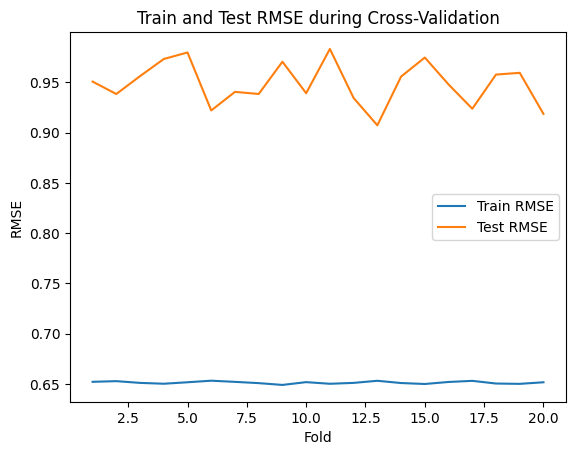

Best RMSE: 0.9519
Best Parameters: {'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.4}


In [85]:
from surprise.model_selection import cross_validate, GridSearchCV
# Load the data into Surprise's Dataset format
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(randomly_dropped_ratings[['user_id', 'restaurant_id', 'Rating']], reader)

# Define the parameter grid for hyperparameter tuning
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.002, 0.005, 0.01], 'reg_all': [0.02, 0.1, 0.4]}

# Perform grid search cross-validation to find the best hyperparameters
gs = GridSearchCV(SVD, param_grid, measures=['RMSE'], cv=5)
gs.fit(data)

# Get the best RMSE score and hyperparameters
best_rmse = gs.best_score['rmse']
best_params = gs.best_params['rmse']

# Create the SVD model with the best hyperparameters
svd = SVD(n_epochs=best_params['n_epochs'], lr_all=best_params['lr_all'], reg_all=best_params['reg_all'])

# Perform cross-validation with the tuned model
results = cross_validate(svd, data, measures=['RMSE'], cv=20, verbose=True, return_train_measures=True)

# Get the RMSE scores for train and test sets
train_rmse = results['train_rmse']
test_rmse = results['test_rmse']

# Plot the RMSE values for train and test sets
plt.plot(range(1, 21), train_rmse, label='Train RMSE')
plt.plot(range(1, 21), test_rmse, label='Test RMSE')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('Train and Test RMSE during Cross-Validation')
plt.legend()
plt.show()

print('Best RMSE: {:.4f}'.format(best_rmse))
print('Best Parameters:', best_params)

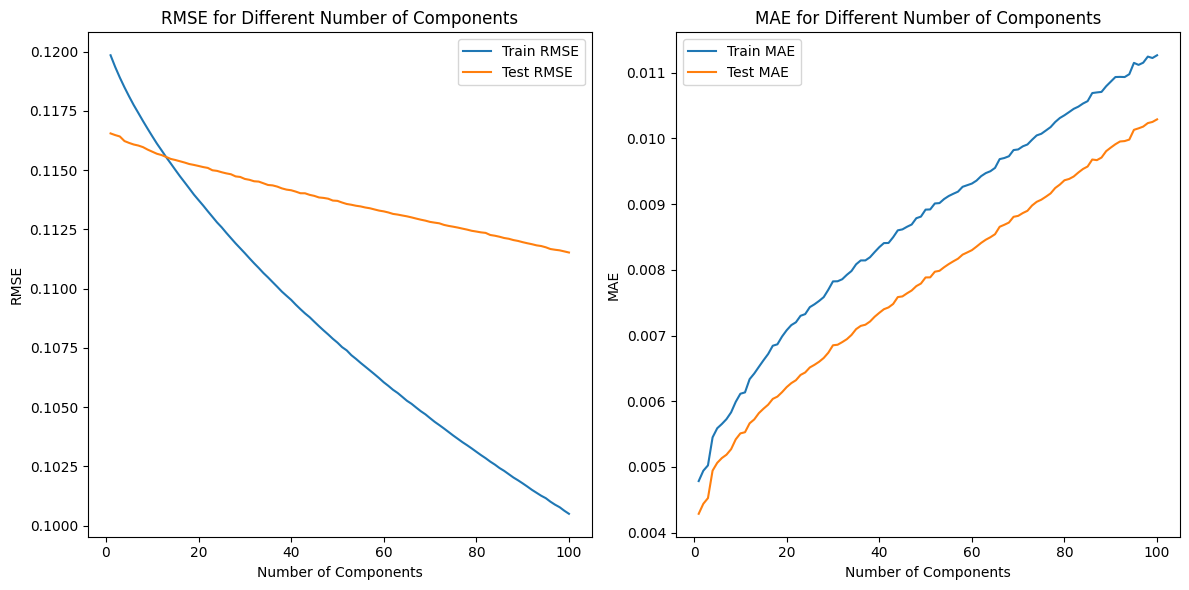

    Number of Components  Train RMSE  Test RMSE  Train MAE  Test MAE
0                      1    0.119848   0.116550   0.004783  0.004285
1                      2    0.119354   0.116480   0.004941  0.004438
2                      3    0.118908   0.116421   0.005023  0.004524
3                      4    0.118496   0.116228   0.005449  0.004943
4                      5    0.118112   0.116149   0.005588  0.005061
..                   ...         ...        ...        ...       ...
95                    96    0.101009   0.111671   0.011121  0.010155
96                    97    0.100883   0.111641   0.011154  0.010181
97                    98    0.100775   0.111616   0.011247  0.010234
98                    99    0.100628   0.111570   0.011225  0.010252
99                   100    0.100498   0.111524   0.011267  0.010291

[100 rows x 5 columns]


In [88]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Create the ratings matrix from the randomly dropped ratings dataframe
ratings_matrix = randomly_dropped_ratings.pivot_table(values='Rating', index='user_id', columns='restaurant_id')

# Fill in missing values with zeros
ratings_matrix_filled = ratings_matrix.fillna(0)

# Split the ratings matrix into train and test sets
train_data, test_data = train_test_split(ratings_matrix_filled, test_size=0.3)

# Set the range of parameter values to test
n_components_range = range(1, 101)

# Initialize lists to store the train and test RMSE and MAE
train_rmse = []
test_rmse = []
train_mae = []
test_mae = []

for n_components in n_components_range:
    # Create the SVD model with the chosen number of components
    svd = TruncatedSVD(n_components=n_components)

    # Fit the SVD model on the train data
    svd.fit(train_data)

    # Make predictions on the train and test data
    train_predictions = svd.inverse_transform(svd.transform(train_data))
    test_predictions = svd.inverse_transform(svd.transform(test_data))

    # Flatten the predictions and actual ratings arrays
    train_predictions_flat = train_predictions.flatten()
    train_actuals_flat = train_data.values.flatten()
    test_predictions_flat = test_predictions.flatten()
    test_actuals_flat = test_data.values.flatten()

    # Compute the train and test RMSE and MAE
    train_rmse.append(np.sqrt(mean_squared_error(train_actuals_flat, train_predictions_flat)))
    test_rmse.append(np.sqrt(mean_squared_error(test_actuals_flat, test_predictions_flat)))
    train_mae.append(mean_absolute_error(train_actuals_flat, train_predictions_flat))
    test_mae.append(mean_absolute_error(test_actuals_flat, test_predictions_flat))

# Plot the RMSE and MAE values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(n_components_range, train_rmse, label='Train RMSE')
plt.plot(n_components_range, test_rmse, label='Test RMSE')
plt.xlabel('Number of Components')
plt.ylabel('RMSE')
plt.title('RMSE for Different Number of Components')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(n_components_range, train_mae, label='Train MAE')
plt.plot(n_components_range, test_mae, label='Test MAE')
plt.xlabel('Number of Components')
plt.ylabel('MAE')
plt.title('MAE for Different Number of Components')
plt.legend()

plt.tight_layout()
plt.show()

# Create a table to display the RMSE and MAE values
results_table = pd.DataFrame({'Number of Components': n_components_range,
                              'Train RMSE': train_rmse,
                              'Test RMSE': test_rmse,
                              'Train MAE': train_mae,
                              'Test MAE': test_mae})
print(results_table)

In [144]:
def generate_recommendations(user_id, n_recommendations, svd_model, ratings, restaurant_data):
    # Get the index of the user in the ratings matrix
    user_index = ratings.index.get_loc(user_id)
    
    # Get the predicted ratings for the user
    user_predictions = svd_model.inverse_transform(svd_model.transform(ratings))
    user_ratings = user_predictions[user_index]

    # Sort the predicted ratings in descending order
    sorted_ratings_indices = np.argsort(user_ratings)[::-1]

    # Get the top recommended restaurant indices
    top_restaurant_indices = sorted_ratings_indices[:n_recommendations]

    # Get the corresponding restaurant IDs
    top_restaurant_ids = ratings.columns[top_restaurant_indices]

    # Get the restaurant names and predicted ratings
    recommendations = []
    for restaurant_id in top_restaurant_ids:
        restaurant_name = restaurant_data[restaurant_data['restaurant_id'] == restaurant_id]['Restaurant'].iloc[0]
        predicted_rating = round(user_ratings[top_restaurant_indices][top_restaurant_ids == restaurant_id][0], 2)
        recommendations.append({'Restaurant': restaurant_name, 'Predicted Rating': predicted_rating})

    return recommendations


# Set the optimal number of components based on the lowest test RMSE or MAE
optimal_n_components = 100

# Create the SVD model with the optimal number of components
svd_model = TruncatedSVD(n_components=optimal_n_components)

# Fit the SVD model on the train data
svd_model.fit(train_data)

# Generate recommendations for a user
user_id = 212
n_recommendations = 20
recommendations = generate_recommendations(user_id, n_recommendations, svd_model, 
                                           ratings_matrix_filled, randomly_dropped_ratings)

# Print the recommendations
print("Top Recommendations for User:", user_id)
for recommendation in recommendations:
    print("Restaurant:", recommendation['Restaurant'], "Predicted Rating:", recommendation['Predicted Rating'])

Top Recommendations for User: 212
Restaurant: Dining In The Dark KL Predicted Rating: 3.38
Restaurant: Tamarind Springs By Samadhi Predicted Rating: 2.72
Restaurant: Tosca Trattoria Italiana at DoubleTree by Hilton Johor Bahru Predicted Rating: 2.0
Restaurant: The Steakhouse KL Predicted Rating: 1.9
Restaurant: Graze Restaurant, Kuala lumpur Predicted Rating: 1.86
Restaurant: Chambers Grill Predicted Rating: 1.82
Restaurant: Favola Italian Restaurant Predicted Rating: 1.61
Restaurant: Curate At Four Seasons Hotel Kuala Lumpur Predicted Rating: 1.5
Restaurant: Nizza Predicted Rating: 1.23
Restaurant: El Cerdo Predicted Rating: 1.2
Restaurant: Cafe BLD at Renaissance Johor Bahru Hotel Predicted Rating: 1.16
Restaurant: Cilantro Restaurant & Wine Bar Predicted Rating: 1.16
Restaurant: Wildflowers Predicted Rating: 1.08
Restaurant: Naughty Nuri's Predicted Rating: 0.88
Restaurant: Chynna Predicted Rating: 0.87
Restaurant: LUCE Osteria Contemporanea Predicted Rating: 0.82
Restaurant: Coppol

# Naive Bayes Classifier

In [93]:
# Using the overall dataset to create this model
ta = tripadvisor_review.copy()

### Further pre-process the dataset to fit into the model

# Initialize the stemmer and stopwords 
st = PorterStemmer()
stopw = set(stopwords.words('english'))

# Function to preprocess and stem the tags
def furtherclean(tags):
    # Tokenize the tags
    tokens = nltk.word_tokenize(tags.lower())
    
    # Remove stop words and stem the tokens
    stemmed_tokens = [st.stem(token) for token in tokens if token not in stopw]
    
    # Join the stemmed tokens back into a string
    preprocessed_tags = ' '.join(stemmed_tokens)
    
    return preprocessed_tags

# Apply the preprocessing function to the 'tags' column
ta2 = ta[ta['sentiment'] != 'Neutral']
ta2['tags'] = ta2['tags'].apply(furtherclean)

# undersampling is done due to positive reviews > negative reviews x10 times
positive_samples = ta2[ta2['sentiment'] == "Positive"]
negative_samples = ta2[ta2['sentiment'] == "Negative"]
negative_count = len(negative_samples)
undersampled_positive_samples = positive_samples.sample(n=negative_count, random_state=42)
balanced_dataset = pd.concat([negative_samples, undersampled_positive_samples])

sentiment_counts = balanced_dataset['sentiment'].value_counts()
print("Total number of each unique value in the 'sentiment' column:")
print(sentiment_counts)

Total number of each unique value in the 'sentiment' column:
sentiment
Negative    10537
Positive    10537
Name: count, dtype: int64


C:\Users\Bryan\AppData\Local\Temp\ipykernel_15676\69334581.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ta2['tags'] = ta2['tags'].apply(furtherclean)


In [94]:
from sklearn.utils import shuffle
# shuffle to avoid order bias
balanced_dataset = shuffle(balanced_dataset, random_state=42)

In [97]:
sia = SentimentIntensityAnalyzer()

# Check polarity of a word using NLTK's sentiment analyzer
def polarity(word):
    sentiment_scores = sia.polarity_scores(word)
    return sentiment_scores['compound']

balanced_dataset['sentiment'] = balanced_dataset['sentiment'].str.lower()

# Create dictionaries of positive and negative words
positive_words = set()
negative_words = set()

for review, sentiment in zip(balanced_dataset['tags'], balanced_dataset['sentiment']):
    words = review.lower().split()
    for word in words:
        if sentiment == "positive" and polarity(word) > 0:  # Check polarity for positive sentiment
            positive_words.add(word)
        elif sentiment == "negative" and polarity(word) < 0:  # Check polarity for negative sentiment
            negative_words.add(word)

# Feature Extraction
def extract_features(text):
    words = set(text.lower().split())
    positive_count = len(words.intersection(positive_words))
    negative_count = len(words.intersection(negative_words))
    return {'positive_count': positive_count, 'negative_count': negative_count}

# Prepare the labeled feature sets
labeled_features = []
for review, sentiment in zip(balanced_dataset['tags'], balanced_dataset['sentiment']):
    features = extract_features(review)
    labeled_features.append((features, sentiment))

# Split the dataset into training and testing sets
train_set, test_set = train_test_split(labeled_features, test_size=0.2, random_state=42)

# Train the Naive Bayes classifier
classifier = NaiveBayesClassifier.train(train_set)

# Make predictions on the test set
y_test = [label for _, label in test_set]
X_test_features = [features for features, _ in test_set]
y_pred = classifier.classify_many(X_test_features)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.773902728351127
Precision: 0.7760777367985335
Recall: 0.773902728351127
F1-score: 0.7735880273964079


In [98]:
balanced_dataset.head()
balanced_dataset['sentiment'] = balanced_dataset['sentiment'].str.lower()


,Author,Rating,Restaurant,Location,sentiment,restaurant_id,user_id,Total_Reviews_By_Restaurant,TotalReviewsGiven,tags,cleaned_restaurant
106662,"summerkopiteaSingapore, Singapore",4.0,Restaurant Zhong Tai,Melaka,positive,1054,75373,59,3,delici chees say tri chees bee guess mind wait...,restaurant zhong tai
92502,"myworld52Berkshire, United Kingdom",5.0,Feringgi Grill,Penang,positive,965,67463,296,1,fine dine restaur base la dress code add sens ...,feringgi grill
139018,AdrianLooiSingapore,1.0,Sushi Zanmai,JB,negative,249,94259,198,1,avoid beef hard request staff lazi stretch one...,sushi zanmai
113096,"hanzer728Kuala Lumpur, Malaysia",2.0,Paya Serai,Shah Alam,negative,1328,80706,704,1,great atmospher poor qualiti food year dinner ...,paya serai
125682,sdlovetotraveldublin,2.0,Bla Bla Bla,Kuching,negative,1829,86723,592,1,disappoint restaur nice ambianc quiet food qui...,bla bla bla


In [154]:
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Extract TP, TN, FP, FN from the confusion matrix
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

# Print the results
print("True Negatives (TN):", TN)
print("False Positives (FP):", FP)
print("False Negatives (FN):", FN)
print("True Positives (TP):", TP)

True Negatives (TN): 1659
False Positives (FP): 459
False Negatives (FN): 478
True Positives (TP): 1619


In [100]:
def predict_sentiment(input_text):
    # Extract features from the input text
    input_feature = extract_features(input_text)

    # Predict the sentiment using the NB classifier
    sentiment = classifier.classify(input_feature)

    return sentiment

user_input = input("Enter your text: ")
predicted_sentiment = predict_sentiment(user_input)

print("Predicted sentiment:", predicted_sentiment)

Enter your text: not good
Predicted sentiment: positive


# --Data Export for Deployment--

In [247]:
dataset_file = "cleaned_rdataset.csv"
dataset = pd.read_csv(dataset_file)
dataset.head()

,Author,Rating,Restaurant,Location,sentiment,restaurant_id,user_id,Total_Reviews_By_Restaurant,TotalReviewsGiven,tags,cleaned_restaurant
0,Journey43268,5.0,Chambers Grill,KL,Positive,1,212,703,38,superb dinner first time dine after been recei...,chambers grill
1,Journey43268,5.0,Chambers Grill,KL,Positive,1,212,703,38,birthday dinner food servic excel by chamber m...,chambers grill
2,Journey43268,5.0,Chambers Grill,KL,Positive,1,212,703,38,excel great food prepar by chef tomahawk perfe...,chambers grill
3,"BobBobGoldenKuala Lumpur, Malaysia",4.0,Chambers Grill,KL,Positive,1,494,703,18,veri nice steak bar is well renov serv great i...,chambers grill
4,Journey43268,5.0,Chambers Grill,KL,Positive,1,212,703,38,tabl side tomahawk tri a is recommend by prese...,chambers grill


In [25]:
userdf = dataset[['user_id', 'Author']].copy()
userdf.head()

,user_id,Author
0,212,Journey43268
1,212,Journey43268
2,212,Journey43268
3,494,"BobBobGoldenKuala Lumpur, Malaysia"
4,212,Journey43268


In [28]:
userdf = userdf.drop_duplicates(subset=['user_id'])

In [29]:
userdf.shape

(8418, 2)

In [30]:
userdf['password'] = userdf.apply(lambda row: 'password', axis=1)

userdf.head()

,user_id,Author,password
0,212,Journey43268,password
3,494,"BobBobGoldenKuala Lumpur, Malaysia",password
13,547,Corrado_foodpasha,password
14,558,"cittabellaKuala Lumpur, Malaysia",password
15,561,TheYumL,password


In [31]:
userdf.to_csv("userdf.csv", index=False)

In [249]:
restaurantdf = dataset[['Restaurant','Location']].copy()
restaurantdf.head()

,Restaurant,Location
0,Chambers Grill,KL
1,Chambers Grill,KL
2,Chambers Grill,KL
3,Chambers Grill,KL
4,Chambers Grill,KL


In [250]:
restaurantdf = restaurantdf.drop_duplicates(subset=['Restaurant'])
restaurantdf.head()

,Restaurant,Location
0,Chambers Grill,KL
27,Positano Risto,KL
33,Sausage KL Cafe & Deli,KL
38,Knowhere Bangsar,KL
40,Ishin Japanese Dining,KL


In [251]:
restaurantdf.shape

(2496, 2)

In [252]:
restaurantdf.to_csv("restaurantdf.csv", index=False)

In [99]:
balanced_dataset.to_csv("nbdf.csv", index=False)

In [246]:
# Testing of Naive Bayes code for deployment
sia = SentimentIntensityAnalyzer()

# Check polarity of a word using NLTK's sentiment analyzer
def polarity(word):
    sentiment_scores = sia.polarity_scores(word)
    return sentiment_scores['compound']

balanced_dataset['sentiment'] = balanced_dataset['sentiment'].str.lower()

# Create dictionaries of positive and negative words
positive_words = set()
negative_words = set()

for review, sentiment in zip(balanced_dataset['tags'], balanced_dataset['sentiment']):
    words = review.lower().split()
    for word in words:
        if sentiment == "positive" and polarity(word) > 0:  # Check polarity for positive sentiment
            positive_words.add(word)
        elif sentiment == "negative" and polarity(word) < 0:  # Check polarity for negative sentiment
            negative_words.add(word)

# Feature Extraction
def extract_features(text):
    words = set(text.lower().split())
    positive_count = len(words.intersection(positive_words))
    negative_count = len(words.intersection(negative_words))
    return {'positive_count': positive_count, 'negative_count': negative_count}

# Prepare the labeled feature sets
labeled_features = []
for review, sentiment in zip(balanced_dataset['tags'], balanced_dataset['sentiment']):
    features = extract_features(review)
    labeled_features.append((features, sentiment))

# Train the Naive Bayes classifier
classifier = NaiveBayesClassifier.train(labeled_features)

def predict_sentiment(input_text):
    # Extract features from the input text
    input_feature = extract_features(input_text)

    # Predict the sentiment using the NB classifier
    sentiment = classifier.classify(input_feature)

    return sentiment

user_input = input("Enter your text: ")
predicted_sentiment = predict_sentiment(user_input)

print("Predicted sentiment:", predicted_sentiment)